# MNIST digit recognition for beginners with a Convolutional Neural Network (CNN) in PyTorch [3/3]

This is the third of three notebooks for beginners where we will tackle MNIST digit recognition using several different approaches:

1. [Using traditional supervised learning methods with sckit-learn [1/3]](https://www.kaggle.com/code/owenpb/mnist-for-beginners-with-scikit-learn-1-3)
2. [Using a standard neural network in PyTorch [2/3]](https://www.kaggle.com/code/owenpb/mnist-for-beginners-neural-net-with-pytorch-2-3)
3. [Using a convolutional neural network (CNN) in PyTorch [3/3]](https://www.kaggle.com/code/owenpb/mnist-for-beginners-cnn-with-pytorch-3-3)

In the previous notebook, we built our first fully-connected neural network (NN) in PyTorch to recognize digits from 0 to 9 from the MNIST dataset, which consists of greyscale images. We constructed an inital model with PyTorch, using two hidden layers followed by a 10-unit output layer with softmax. Finally, we performed hyperparameter tuning, finding good values for the learning rate $\alpha$, number of hidden units, weight decay (L2 penalty), and dropout $p$.

In this notebook, we will explore training a Convolutional Neural Network (CNN) in PyTorch, an architecture particularly well suited for image classification tasks. The initial steps below (i.e. preparing our Dataset and DataLoaders) are similar to our previous notebook, however the construction of the network is quite different.

# 1. Import libraries

In [1]:
import torch
import torchvision
import torch.nn as nn
from torch.utils.data import TensorDataset, Dataset, DataLoader, Subset, random_split
from sklearn.model_selection import train_test_split
from torchvision import transforms

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 2. Read and display MNIST data

First let's read the training data csv file into a pandas dataframe. We'll separate the target labels (y) from the pixel values (X), and also display a few example MNIST images along with their label.

In [2]:
# Read the training data csv file into a pandas dataframe:
data = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [3]:
# Print out the pandas dataframe:
data

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Separate into pixel data (X) and target labels (y):
X, y = data.iloc[:, 1:], data['label']
X = X.to_numpy()
y = y.to_numpy()

Here we display a single example image along with its target label:

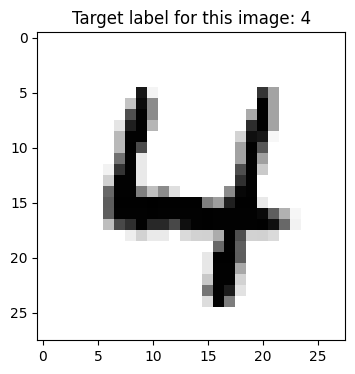

In [5]:
image_label = 42

plt.figure(figsize=(4, 4))
plt.imshow(X[42].reshape(28, 28), cmap="binary")
plt.title(f'Target label for this image: {y[42]}')
plt.show()

Let's display some more examples from the MNIST dataset. In the upper-right corner of each image, the true label is shown in blue:

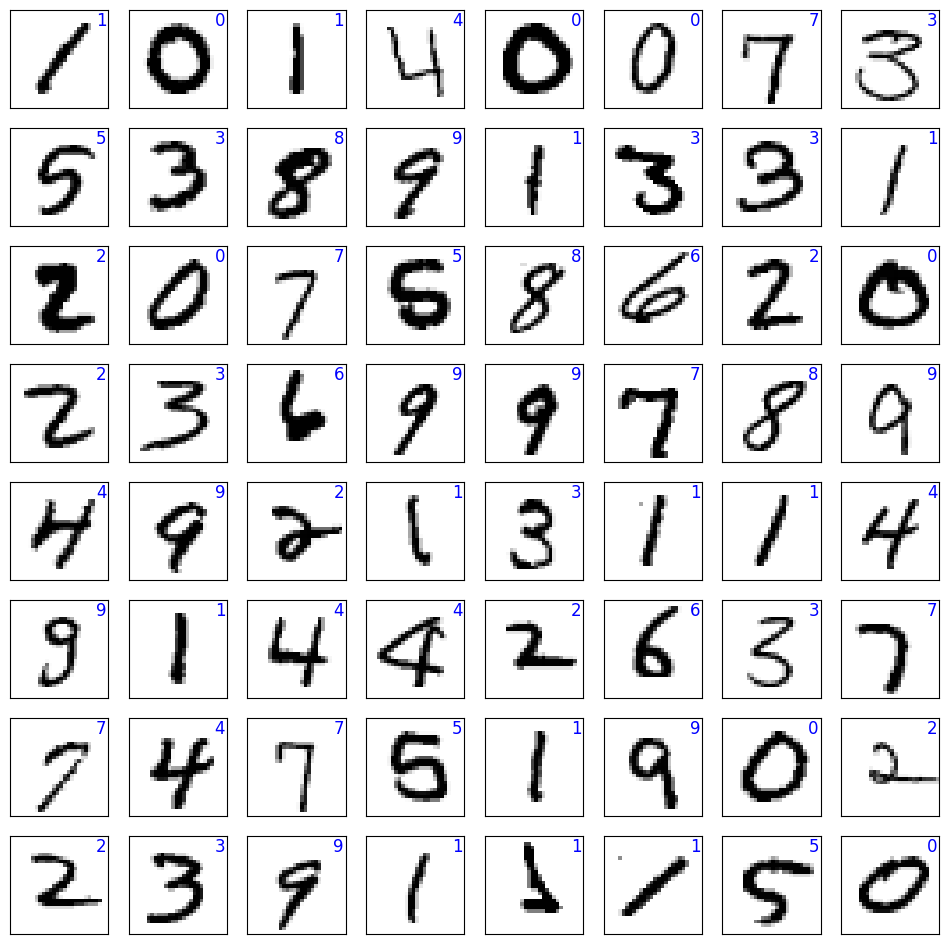

In [6]:
fig, axs = plt.subplots(8, 8, figsize=(12, 12))
index = 0

for i in range(8):
    for j in range(8):

        axs[i, j].imshow(X[index].reshape(28, 28), cmap="binary")
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].text(x=24, y=4, s=str(y[index]), c='blue', size=12)
        index += 1

# 3. Creating Dataset and DataLoaders

First we will standardize pixel values. Currently these are integers in the range $[0,255]$, which we transform so they are in the interval $[0,1]$.

Then we convert our X and y arrays into torch tensors. We will be feeding the MNIST images to a neural network which expects each image to have dimensions $[C, H, W]$. Here $C$ is the number of channels, which is just $1$ for a greyscale image, while $H$ and $W$ are the height and width respectively. Therefore we'll also need to reshape our rows of pixel values (of length $784$) to have dimensions of $28 \times 28$. We can also insert an extra dimension for the channel $C$ using torch.unsqueeze. Note that the very first dimension (with index 0) of the entire tensor X corresponds to $N$, the number of samples, i.e. X ends up having dimensions $[N, C, H, W] = [42000, 1, 28, 28]$.

The next step is to arrange our X and y data into a PyTorch Dataset. Rather than define a custom Dataset class, for this task we can simply use the built-in TensorDataset class. 

In [7]:
np.unique(X)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [8]:
# Standardize pixel value to range [0, 1]:
X = X / 255

# Convert numpy arrays to torch tensors:

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.long)

print(f'Previous X dimensions: {X_tensor.shape}')

# Get input X in [N, C, H, W] format for input to neural network
X_tensor = X_tensor.reshape(X_tensor.shape[0], 28, 28)
X_tensor = torch.unsqueeze(X_tensor, 1)

print(f'New X dimensions: {X_tensor.shape}')

# Create PyTorch Dataset using TensorDataset(input_features, labels):
mnist_dataset = TensorDataset(X_tensor, y_tensor)   

Previous X dimensions: torch.Size([42000, 784])
New X dimensions: torch.Size([42000, 1, 28, 28])


In [9]:
mnist_dataset

Now we split our data into separate training and validation sets. We'll use 36000 samples for training and the remaining 6000 for validation. Using our full Dataset as input, this can be achieved with the random_split function from torch.utils.data. For reproducibility we fix the random seed used here.

Next, we create DataLoaders for both our training and validation sets. We also need to specifiy the batch size at this stage. Let's choose batch_size=64.

In [10]:
training_set, validation_set = random_split(mnist_dataset, [36000, 6000], generator=torch.Generator().manual_seed(1))

batch_size = 64
torch.manual_seed(1)

train_dl = DataLoader(training_set, batch_size, shuffle=True)
valid_dl = DataLoader(validation_set, batch_size, shuffle=True)

In [11]:
# Check the dimensions of X and y data in each minibatch:

print(f'Shape of X minibatch: {next(iter(train_dl))[0].shape}')
print(f'Shape of y minibatch: {next(iter(train_dl))[1].shape}')

Shape of X minibatch: torch.Size([64, 1, 28, 28])
Shape of y minibatch: torch.Size([64])


# 4. Initial model: building a CNN in PyTorch

Let's use nn.Sequential to build an initial CNN with two convolutional layers, one hidden layer, and an output layer. To start with, for our two convolution layers, let us choose the number of filters as $32$ and $64$. These layers shall have ReLU activation followed by Max Pooling, where the kernel size is chosen such that the image height and width is halved at this step. After the convolutions are performed, the final output is flattened and passed to a linear layer with ReLU activation followed by dropout with probability $p$. For now let us choose this linear layer to have $1024$ units. Later we will experiment with tuning the number of units, filters, and dropout probability to achieve optimal performance. Finally, since this is a classification task with possible classes being the digits $0$ to $9$, we have a final output layer with $10$ units.

Note that for each Conv2d layer we use 'same' padding so that the output height $H$
and width $W$ is unchanged from the input height and width. Our greyscale images have only $1$ channel, and initially have $H=W=28$. However, after two Max Pooling operations our images are reduced to $H=W=7$. Since we choose $64$ filters in our second Conv2d layer here, the output of our final Max Pooling has dimensions of $(N, 64, 7, 7)$, in $[N, C, H, W]$ format (where $N$ is our batch size, which also happens to be $64$). Hence after using nn.Flatten, the number of input features passed to nn.Linear is $64 \times 7 \times 7 = 3136$.

In [12]:
initial_model = nn.Sequential(

    nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Flatten(),
    nn.Linear(3136, 1024),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(1024, 10)
    
)

We use CrossEntropyLoss for the loss function for this multi-class classification task. Note that in PyTorch, this loss function expects the *logits* as input i.e. the number one would typically pass into a Softmax function at the output layer. Therefore when we previously specified the layers of the neural network in nn.Sequential(), we didn't need a final Softmax layer.

We also specify here the number of epochs to train for, which we set to 20, and also our optimizer (we will choose Adam).

In [13]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(initial_model.parameters(), lr=0.001)
num_epochs = 20
torch.manual_seed(1)

Now we define the **train** function, which will return histories of both loss and accuracy for both the training set and our validation set.

In [16]:
def train(model, num_epochs, train_dl, valid_dl):
    
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs
    
    for epoch in range(num_epochs):
        
        model.train()
        
        for x_batch, y_batch in train_dl:
#             import pdb;pdb.set_trace()
            pred = model(x_batch)    # Get predicted values for this batch     
            loss = loss_fn(pred, y_batch)    # Calculate the loss
            loss.backward()    # Compute gradients
            optimizer.step()    # Update parameters
            optimizer.zero_grad()    # Reset grads to zero
            
            loss_hist_train[epoch] += loss.item() * y_batch.size(0)    # Total loss for the whole batch
            
            # Each image in batch has predicted class probabilities for classes 0 to 9.
            # Take highest class probability (our predicted label) and check if it equals true label.
            # Therefore is_correct = 1 if image prediction is correct, 0 otherwise.
            
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            
            accuracy_hist_train[epoch] += is_correct.sum()    # Number of correctly predicted images in this batch
        
        
        loss_hist_train[epoch] /= len(train_dl.dataset)    # After accumulating total losses from each batch, calculate loss per sample.
        accuracy_hist_train[epoch] /= len(train_dl.dataset)    # After getting total number of correct preds across all batches, calculate accuracy per sample (so between 0 and 1). 
    
    
        
        # Put model in eval mode for evaluating on validation set
        model.eval()
        
        with torch.no_grad():     # Disable gradient calculation, since we do not need this for getting validation set accuracy and loss
            
            for x_batch, y_batch in valid_dl:
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item() * y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum()
                
        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)
        
        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f}    val_accuracy: {accuracy_hist_valid[epoch]:.4f} ')
        
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [18]:
initial_hist = train(initial_model, 3, train_dl, valid_dl)

Epoch 1 accuracy: 0.9889    val_accuracy: 0.9883 
Epoch 2 accuracy: 0.9911    val_accuracy: 0.9885 
Epoch 3 accuracy: 0.9935    val_accuracy: 0.9892 


# 5. Visualizing training and validation loss

After calling the **train** function we now have histories of the training loss, validation loss, training accuracy, and validation accuracy. Let's plot these against epoch number:

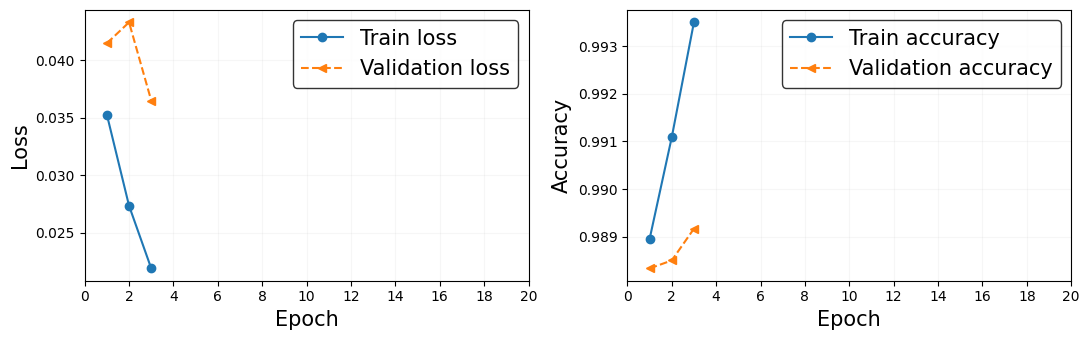

In [19]:
x_arr = np.arange(len(initial_hist[0])) + 1
fig = plt.figure(figsize=(11, 3.5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, initial_hist[0], '-o', label='Train loss')
ax.plot(x_arr, initial_hist[1], '--<', label='Validation loss')
ax.legend(fontsize=15, frameon=True, edgecolor='k')
ax.set_xlabel('Epoch', size=15)
ax.set_xticks(np.arange(0, 22, 2))
ax.set_ylabel('Loss', size=15)
ax.grid(alpha=0.1)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, initial_hist[2], '-o', label='Train accuracy')
ax.plot(x_arr, initial_hist[3], '--<', label='Validation accuracy')
ax.legend(fontsize=15, frameon=True, edgecolor='k')
ax.set_xlabel('Epoch', size=15)
ax.set_xticks(np.arange(0, 22, 2))
ax.set_ylabel('Accuracy', size=15)
ax.grid(alpha=0.1)
plt.tight_layout()
plt.show()

In [20]:
initial_best_valid_acc = round(max(initial_hist[3]).item(), 6)
print(initial_best_valid_acc)
print('\n')
print(f'Best validation set accuracy: {initial_best_valid_acc * 100}%')

0.989167


Best validation set accuracy: 98.9167%


Our CNN achieves a classification accuracy around $99\%$ on the validation dataset! Note we obtained our training and validation sets by partitioning the fully labeled dataset (train.csv) provided by Kaggle. However, we now need to make final predictions for images in the unlabeled dataset (test.csv), which will constitute our submission file for the Digit Recognizer competition.

# 6. Final test predictions and submission

There are 28000 unlabed images in test.csv. We need to transform the data in the same manner as our training data. That is, we both standardize the pixel values and reshape the input tensor to have dimensions $[N, C, H, W] = [28000, 1, 28, 28]$.

In [21]:
# Read in the unlabeled test images and standardize:

X_test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
X_test = X_test.to_numpy()
X_test = X_test / 255

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
X_test_tensor = X_test_tensor.reshape(X_test_tensor.shape[0], 28, 28)
X_test_tensor = torch.unsqueeze(X_test_tensor, 1)

In [22]:
X_test_tensor.shape

torch.Size([28000, 1, 28, 28])

In [23]:
# Our NN outputs logits for each class.
# Use torch.argmax to get our predicted class for each test image.

test_predicted_logits = initial_model(X_test_tensor)
test_predicted_classes = torch.argmax(test_predicted_logits, dim=1)

In [24]:
test_predicted_logits

tensor([[ -2.0792,  -5.7594,  17.9424,  ...,  -6.1288,  -4.1178,  -9.0122],
        [ 15.3670,  -9.3911,  -5.3689,  ...,  -5.4550,  -5.2232,  -4.9304],
        [ -6.9553,  -7.9637,  -4.0086,  ...,  -4.9811,   1.5629,  10.1740],
        ...,
        [-13.8389,  -5.1058,  -3.5013,  ...,  -3.2660,  -0.2796,  -2.3378],
        [ -7.8041, -10.4456, -10.1044,  ...,  -1.2965,  -4.5428,  14.1797],
        [ -4.3714,  -4.4738,  18.1351,  ...,  -4.9608,  -0.8893,  -9.8859]],
       grad_fn=<AddmmBackward0>)

In [27]:
test_predicted_classes

tensor([2, 0, 9,  ..., 3, 9, 2])

In [ ]:
# Convert predictions to numpy array, and make array of image_ids for submission file:

test_predicted_classes = test_predicted_classes.numpy()
image_ids = np.arange(1, len(test_predicted_classes)+1)

In [ ]:
# Create final submission.csv file:

df = pd.DataFrame({"ImageId":image_ids, "Label":test_predicted_classes})
df.to_csv("submission.csv", index=False)

This is the final notebook in a series of three notebooks for beginners where we will tackle MNIST digit recognition using several different approaches. See below for links to these earlier notebooks, where we apply a variety of supervised learning algorithms in scikit-learn, and build a standard fully-connected NN in PyTorch for MNIST digit classification:

1. [Using traditional supervised learning methods with sckit-learn [1/3]](https://www.kaggle.com/code/owenpb/mnist-for-beginners-with-scikit-learn-1-3)
2. [Using a standard neural network in PyTorch [2/3]](https://www.kaggle.com/code/owenpb/mnist-for-beginners-neural-net-with-pytorch-2-3)
3. [Using a convolutional neural network (CNN) in PyTorch [3/3]](https://www.kaggle.com/code/owenpb/mnist-for-beginners-cnn-with-pytorch-3-3)